<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/notebooks/delfi_moment_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook demonstrates estimation of the marginal posteriors using MomentNetworks

# Load modules

In [1]:
!pip install emcee getdist

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy import fftpack

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.layers import concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [3]:
import os, sys
import random
import emcee as mc
import getdist
from getdist import plots, MCSamples
import scipy.interpolate as interpolate
import time
%matplotlib inline

# Generate high dim training data

In [4]:
size=20
n_training = 100000
cov_signal_fourier = np.identity(size)*np.logspace(size,size*0.9,size)/np.sum(np.logspace(size,size*0.9,size))
cov_noise = np.identity(size)*0.1
cov_noise_inv = np.linalg.pinv(cov_noise)

In [5]:
training_z = np.random.multivariate_normal(np.zeros(size),cov_signal_fourier,n_training) + \
                  1j*np.random.multivariate_normal(np.zeros(size), cov_signal_fourier,n_training)
training_z = np.fft.fft(training_z).real

training_data = training_z + np.random.multivariate_normal(np.zeros(size),cov_noise,n_training)


training_z_obs = training_z[0]
training_data_obs = training_data[0]
training_z = training_z[1:]
training_data = training_data[1:]

In [6]:
cov_signal = np.identity(size)*0.

for i in range(n_training-1):
  cov_signal += np.outer(training_z[i],training_z[i]) 

cov_signal = cov_signal/np.float(n_training-1.)

cov_signal_inv = np.linalg.pinv(cov_signal)

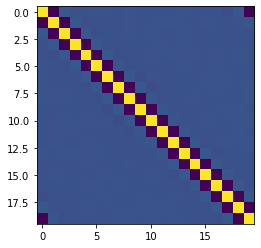

In [7]:
plt.imshow(cov_signal_inv)

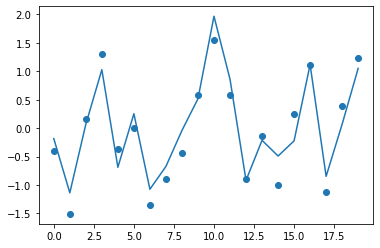

In [8]:
plt.plot(training_z_obs)
plt.scatter(np.arange(size),training_data_obs)

# Moment network variance estimation

In [9]:
class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(150, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x3 = Dense(100, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)
        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mse')

        return dense_model

In [10]:
model_instance = simple_leaky(size,size, learning_rate=1e-4)
regression = model_instance.model()

20
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)           

In [11]:
history = regression.fit(training_data[:80000],
                               training_z[:80000],
                               epochs =20,batch_size =50, shuffle=True,
                               validation_data = (training_data[80000:],
                               training_z[80000:]))

Epoch 1/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3324 - val_loss: 0.1157
Epoch 2/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1031 - val_loss: 0.0992
Epoch 3/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0978 - val_loss: 0.0970
Epoch 4/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0960 - val_loss: 0.0958
Epoch 5/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0949 - val_loss: 0.0955
Epoch 6/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0942 - val_loss: 0.0945
Epoch 7/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0936 - val_loss: 0.0939
Epoch 8/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0931 - val_loss: 0.0931
Epoch 9/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0927 - val_loss: 0.0933
Epoch 10/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.092

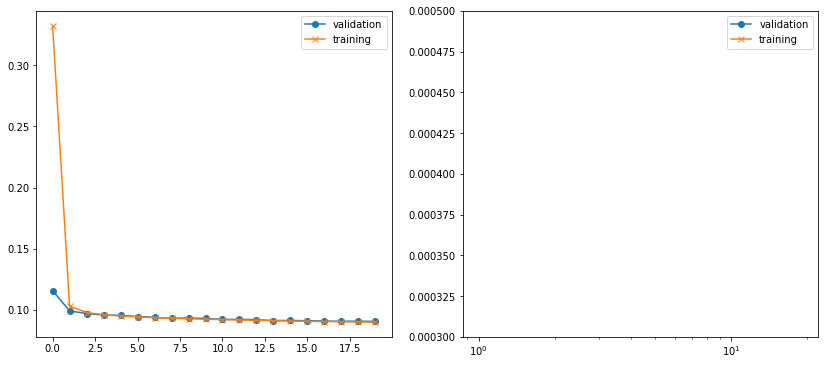

In [12]:
_ = plt.figure(figsize = (14,6))
_ = plt.subplot(121), plt.plot(history.history['val_loss'], marker = 'o', label = 'validation')
_ = plt.plot(history.history['loss'], marker = 'x', label = 'training'), plt.legend()

_ = plt.subplot(122), plt.xscale('log')
_ = plt.ylim(0.1*np.min(history.history['val_loss']), 4*np.max(history.history['loss']))
_ = plt.plot(history.history['val_loss'], marker = 'o', label = 'validation')
_ = plt.plot(history.history['loss'], marker = 'x', label = 'training'), plt.legend(), plt.ylim(3e-4,5e-4)

In [13]:
predicted_mean = regression.predict(np.atleast_2d(training_data))

In [14]:
training_var_unknown_mean = (training_z-regression.predict(np.atleast_2d(training_data)))**2.

In [15]:
model_instance = simple_leaky(size,size, learning_rate=1e-4)
regression_var_unknown_mean = model_instance.model()

20
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               2100      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               15150     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               15100     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100)           

In [16]:
history = regression_var_unknown_mean.fit(training_data[:80000],
                               training_var_unknown_mean[:80000],
                               epochs =20,batch_size =50, shuffle=True,
                               validation_data = (training_data[80000:],
                               training_var_unknown_mean[80000:]))

Epoch 1/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 2/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 3/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 4/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 5/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 6/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 7/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 8/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 9/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 10/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.016

In [17]:
predicted_var_obs = (regression_var_unknown_mean.predict(np.atleast_2d(training_data_obs[:]))[0])
print(predicted_var_obs)

[0.0913494  0.09175257 0.0984609  0.08630977 0.09629921 0.08517173
 0.09388619 0.09815239 0.10242485 0.09514978 0.08891419 0.08757548
 0.07541386 0.08385994 0.09365827 0.0871662  0.08847629 0.09163055
 0.09809893 0.09461916]


In [18]:
(predicted_var_obs)

array([0.0913494 , 0.09175257, 0.0984609 , 0.08630977, 0.09629921,
       0.08517173, 0.09388619, 0.09815239, 0.10242485, 0.09514978,
       0.08891419, 0.08757548, 0.07541386, 0.08385994, 0.09365827,
       0.0871662 , 0.08847629, 0.09163055, 0.09809893, 0.09461916],
      dtype=float32)

# Sample true posterior

In [19]:
def log_prior(theta, data,cov_signal_inv):
    return -0.5*np.inner(theta,np.inner(cov_signal_inv,theta))

def log_likelihood(theta, data,cov_noise_inv):
    return -0.5*np.inner(theta-data,np.inner(cov_noise_inv,theta-data))

def log_posterior_delfi(theta, data,cov_signal_inv):
    return log_prior(theta, data,cov_signal_inv) + DelfiEnsemble.log_likelihood_stacked(theta,data=data) 

def log_posterior_likelihood(theta, data,cov_signal_inv,cov_noise_inv):
    return log_prior(theta, data,cov_signal_inv)  + log_likelihood(theta, data,cov_noise_inv)


In [20]:
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/array of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [21]:
n_dim=size
n_burn=100
n_steps = 10000
n_walkers = 2* n_dim



sampler_likelihood = mc.EnsembleSampler(n_walkers, n_dim, log_posterior_likelihood,
                             args=(training_data_obs,cov_signal_inv,cov_noise_inv,))

In [22]:
theta_expected_mean = [0.1]*size

theta0 = np.array([list(initial_parameters(theta_expected_mean, 1)) for i in range(n_walkers)])

In [23]:
t = time.time()
_ =sampler_likelihood.run_mcmc(theta0, n_steps) 

print(time.time() - t)

flat_samples_likelihood = sampler_likelihood.get_chain(discard=n_burn, flat=True)
print(flat_samples_likelihood.shape)

7.460081577301025
(396000, 20)


In [24]:
np.var(flat_samples_likelihood,axis=0)

array([0.08811277, 0.10494849, 0.08686464, 0.09323797, 0.0885663 ,
       0.09150431, 0.11319144, 0.0946435 , 0.09161692, 0.09235554,
       0.09006216, 0.09440961, 0.09080185, 0.08853304, 0.08558484,
       0.08559443, 0.10143171, 0.0954529 , 0.08828521, 0.09569998])

In [ ]:
names = ["x%s"%i for i in range(size)]
labels =  ["x_%s"%i for i in range(size)]
samples2 = MCSamples(samples=flat_samples_likelihood,names = names, labels = labels, label='lik',
               settings={'smooth_scale_2D':1})

g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True)

Removed no burn in
